In [158]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, log_loss, roc_auc_score,make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(style="darkgrid",font_scale=1.5)
pd.set_option("display.max.rows",None)
pd.set_option("display.max.columns",None)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Global Functions

# Place Transported at the end of the df

In [159]:
def transported_to_end(df):
    transported_col = df.pop('Transported')
    # Place it at the end of the DataFrame
    df['Transported'] = transported_col

## Load the Data

In [160]:
train_df = pd.read_csv("train.csv",  delimiter=',', header=0)
test_df = pd.read_csv("test.csv", delimiter=',', header=0)

### Check size of data

In [161]:
print("Training Dataset shape is: ",train_df.shape)

Training Dataset shape is:  (8693, 14)


# Data Preprocessing
### Check duplicates and remove data

In [162]:
def deduplicate(df):
    df.drop_duplicates(inplace=True)
    
deduplicate(train_df)
deduplicate(test_df)

## Check Missing Data

Check if we need to remove a feature by checking percentage missing values of a feature

Check if we need to remove an instance if it has too many missing data

if its a low value we later will fill na values

In [163]:
def display_missing_stats(df):
    missing_values_count = df.isnull().sum()

    # Calculate the percentage of missing values per feature
    missing_values_percentage = (missing_values_count / len(df)) * 100

    # Create a DataFrame to display the results
    missing_data_info = pd.DataFrame({
        'Missing Values': missing_values_count,
        'Percentage Missing': missing_values_percentage
    })
    print(missing_data_info)

In [164]:
print('Missing Data: Training_DF\n')
display_missing_stats(train_df)

Missing Data: Training_DF

              Missing Values  Percentage Missing
PassengerId                0            0.000000
HomePlanet               201            2.312205
CryoSleep                217            2.496261
Cabin                    199            2.289198
Destination              182            2.093639
Age                      179            2.059128
VIP                      203            2.335212
RoomService              181            2.082135
FoodCourt                183            2.105142
ShoppingMall             208            2.392730
Spa                      183            2.105142
VRDeck                   188            2.162660
Name                     200            2.300702
Transported                0            0.000000


## Remove Missing Data

In [165]:
drop_columns = ['PassengerId', 'Cabin']
train_df.dropna(subset=drop_columns, inplace=True)
display_missing_stats(train_df)
print("Training Dataset shape is: ",train_df.shape)

              Missing Values  Percentage Missing
PassengerId                0            0.000000
HomePlanet               195            2.295738
CryoSleep                210            2.472333
Cabin                      0            0.000000
Destination              178            2.095597
Age                      175            2.060278
VIP                      197            2.319284
RoomService              177            2.083824
FoodCourt                178            2.095597
ShoppingMall             206            2.425241
Spa                      181            2.130916
VRDeck                   184            2.166235
Name                     198            2.331057
Transported                0            0.000000
Training Dataset shape is:  (8494, 14)


## Fill Missing

In [166]:
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [167]:
mode_columns = ['CryoSleep', 'Destination', 'VIP', 'Name', 'HomePlanet']
mean_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Fill missing values with mode for mode_columns
for column in mode_columns:
    mode_value = train_df[column].mode()[0]
    train_df[column].fillna(mode_value, inplace=True)

# Fill missing values with mean for mean_columns
for column in mean_columns:
    mean_value = train_df[column].mean()
    train_df[column].fillna(mean_value, inplace=True)


display_missing_stats(train_df)
print("Training Dataset shape is: ",train_df.shape)

              Missing Values  Percentage Missing
PassengerId                0                 0.0
HomePlanet                 0                 0.0
CryoSleep                  0                 0.0
Cabin                      0                 0.0
Destination                0                 0.0
Age                        0                 0.0
VIP                        0                 0.0
RoomService                0                 0.0
FoodCourt                  0                 0.0
ShoppingMall               0                 0.0
Spa                        0                 0.0
VRDeck                     0                 0.0
Name                       0                 0.0
Transported                0                 0.0
Training Dataset shape is:  (8494, 14)


### Change boolean features from string to int

In [168]:
train_df[['CryoSleep', 'VIP', 'Transported']] = train_df[['CryoSleep', 'VIP', 'Transported']].replace({True: 1, False: 0})

## Check Outliers

In [169]:
def get_df_name(df):
    # Use globals() to obtain the variable name as a string
    for name, var in globals().items():
        if var is df:
            return name
    return None  # Return None if the DataFrame is not found

# Selecting only numerical columns for outlier detection
def show_outliers(df):
    numerical_columns = df.select_dtypes(include=['float64']).columns

    # Display summary statistics for numerical columns
    df[numerical_columns].describe()

    # Display box plots for numerical columns
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df[numerical_columns])
    plt.title(f'Box plots of Numerical Columns {get_df_name(df)}')

    plt.show()

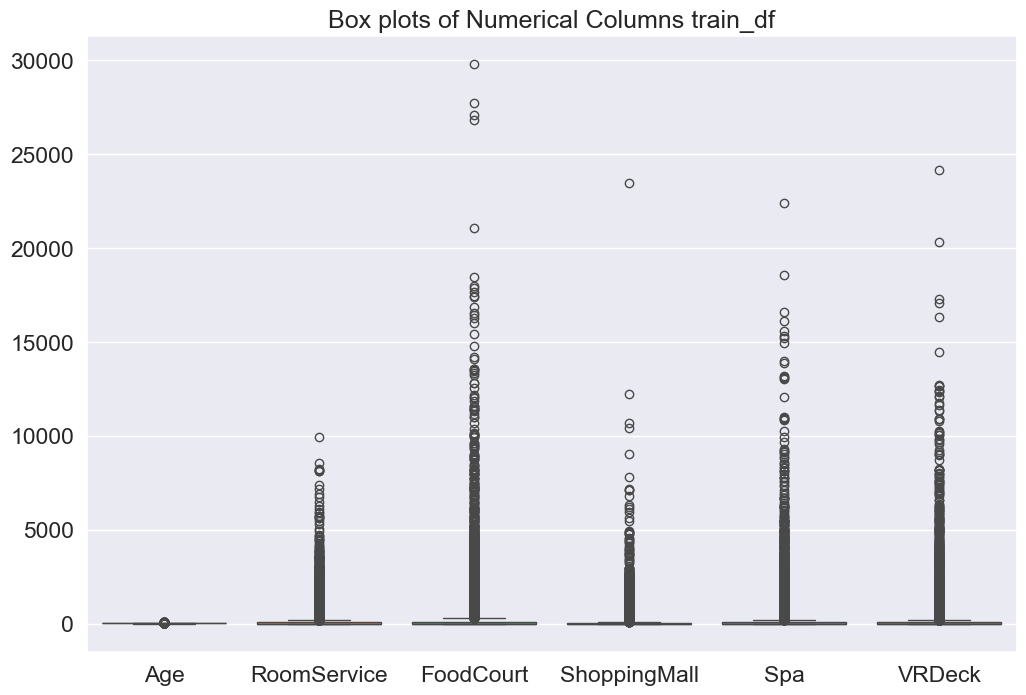

In [170]:
show_outliers(train_df)

## Feature Engineering

## New Features from PassengerID
PassengerId -> gggg_pp, 
- g -> group passenger is travelling with
- p -> # people within group
create new feature for group size
create a new feature for solo traveling

In [171]:
def passengerid_new_features(df):
    #Splitting Group and Member values from "PassengerId" column.
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["Member_Number"] =df["PassengerId"].apply(lambda x: x.split("_")[1])

    #Grouping the "Group" feature with respect to "member" feature to check which group is travelling with how many members
    x = df.groupby("Group")["Member_Number"].count().sort_values()

    #Creating a set of group values which are travelling with more than 1 members.
    y = set(x[x>1].index)

    #Creating a new feature "Group_size" which will indicate each group number of members.
    df["Group_Size"]=0
    for i in x.items():
        df.loc[df["Group"] == i[0], "Group_Size"] = i[1]

    # Adding isInGroup feature
    df['isInGroup'] = df['Group_Size'] > 1

    # Dropping unnecessary columns
    df.drop(columns=["PassengerId", "Group", "Member_Number"], inplace=True)

In [172]:
passengerid_new_features(train_df)

## New Features from Cabin
Create new Features from Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [173]:
def cabin_new_features(df):
    df["Cabin"].fillna("np.nan/np.nan/np.nan",inplace=True) 

    # Create new features: Deck, CabinNumber, Side
    df['Cabin_Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0]).replace("np.nan",np.nan)
    df['Cabin_Number'] = df['Cabin'].apply(lambda x: x.split('/')[1]).replace("np.nan",np.nan)
    df['Cabin_Side'] = df['Cabin'].apply(lambda x: x.split('/')[2]).replace("np.nan",np.nan)

    df.drop('Cabin',axis=1, inplace=True)

In [174]:
cabin_new_features(train_df)

# Total Expenditure
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck summed up

In [175]:
def luxury_amenities_new_feature(df):
    df['Total_Expenditure'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [176]:
luxury_amenities_new_feature(train_df)

# Graphs and Figures

## Transported Distribution

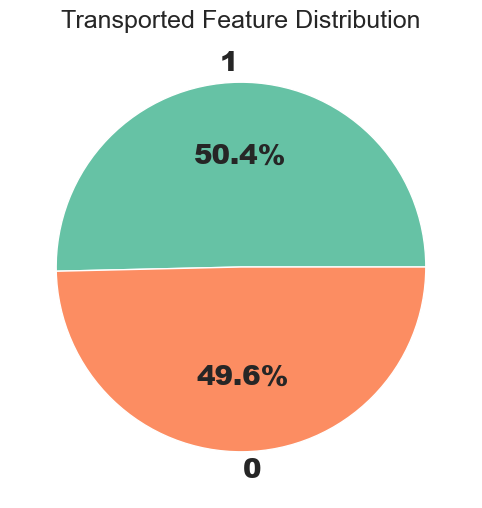

In [177]:
plt.figure(figsize=(10,6))
plt.pie(train_df["Transported"].value_counts(),labels=train_df["Transported"].value_counts().keys(),autopct="%1.1f%%",
       textprops={"fontsize":20,"fontweight":"black"},colors=sns.color_palette("Set2"))
plt.title("Transported Feature Distribution");

## Current Dataframe After Processing

In [178]:
def set_teleported_last(df):
    if 'Transported' in df.columns:
        transported_col = df.pop('Transported')
        df['Transported'] = transported_col

In [179]:
set_teleported_last(train_df)

train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group_Size,isInGroup,Cabin_Deck,Cabin_Number,Cabin_Side,Total_Expenditure,Transported
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1,False,B,0,P,0.0,0
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,False,F,0,S,736.0,1
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,2,True,A,0,S,10383.0,0
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,2,True,A,0,S,5176.0,0
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,False,F,1,S,1091.0,1


### Compare HomePlanet with Transported

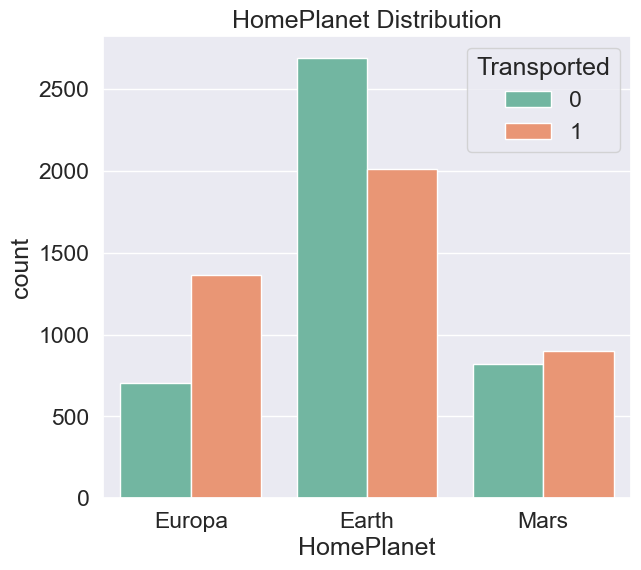

In [180]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='HomePlanet', hue='Transported', data=train_df, palette="Set2")
plt.title("HomePlanet Distribution")
plt.show()

### Compare CryoSleep with Transported

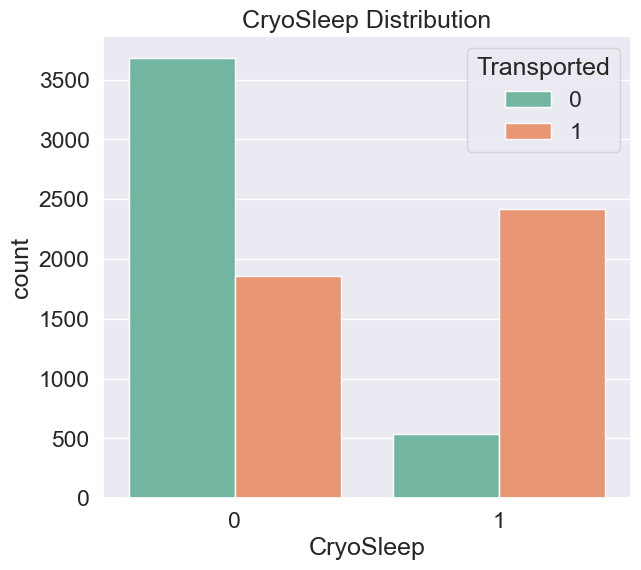

In [181]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='CryoSleep', hue='Transported', data=train_df, palette="Set2")
plt.title("CryoSleep Distribution")
plt.show()

### Compare Destination with Transported

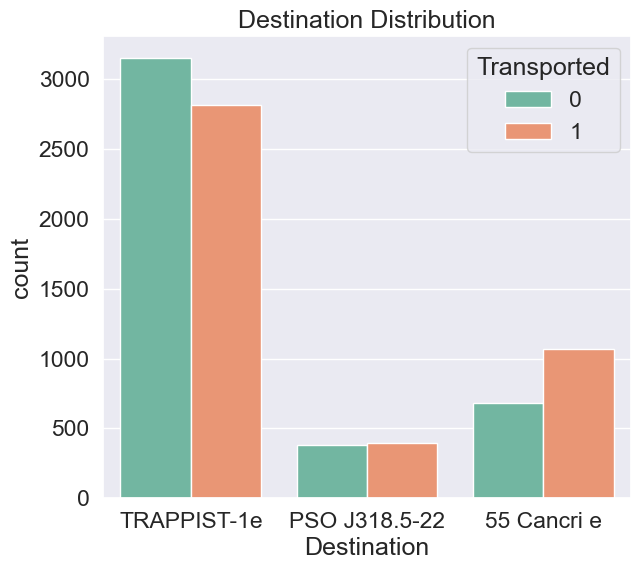

In [182]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='Destination', hue='Transported', data=train_df, palette="Set2")
plt.title("Destination Distribution")
plt.show()

### Compare Age with Transported

Show age distribution without grouping

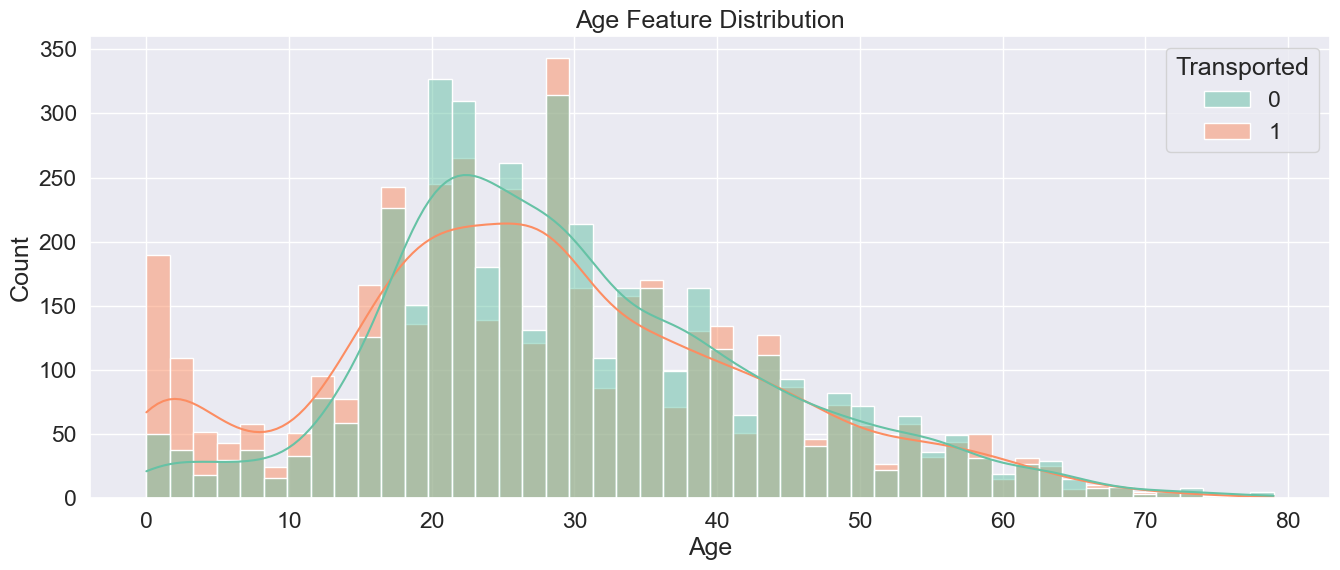

In [183]:
plt.figure(figsize=(16,6))
sns.histplot(x=train_df["Age"],hue="Transported",data=train_df,kde=True,palette="Set2")
plt.title("Age Feature Distribution");

Find the Age range, then create age groups of 5

In [184]:
age_range = train_df['Age'].describe()[['min', 'max']]
print(age_range)
train_df['Age_Group'] = pd.cut(train_df['Age'], bins=range(0, int(train_df['Age'].max()) + 11, 10), right=False, labels=[f'{i}-{i+9}' for i in range(0, int(train_df['Age'].max()) + 1, 10)])

min     0.0
max    79.0
Name: Age, dtype: float64


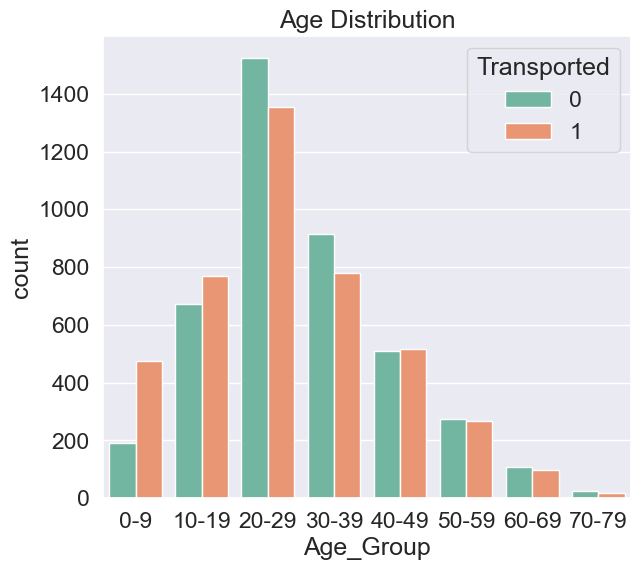

In [185]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='Age_Group', hue='Transported', data=train_df, palette="Set2")
plt.title("Age Distribution")
plt.show()

### Compare VIP with Transported

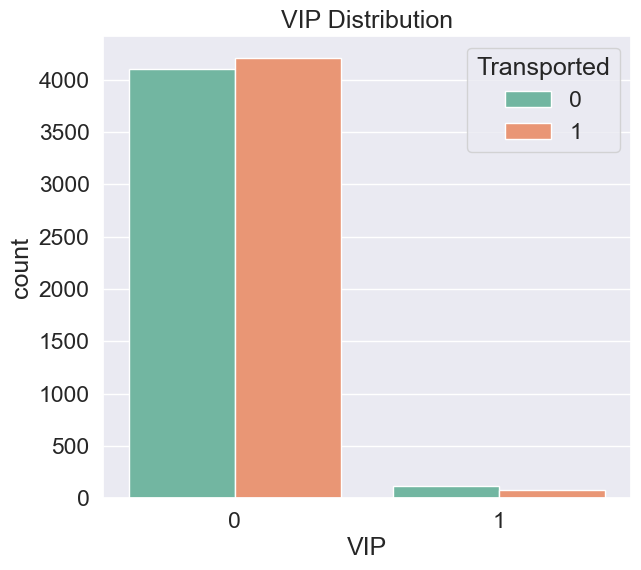

In [186]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='VIP', hue='Transported', data=train_df, palette="Set2")
plt.title("VIP Distribution")
plt.show()

Show proportion of diffence

In [187]:
target_count = train_df['VIP'].value_counts()
print('VIP:', target_count[1])
print('Non_VIP:', target_count[0])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

VIP: 193
Non_VIP: 8301
Proportion: 43.01 : 1


### Compare Group_Size with Transported

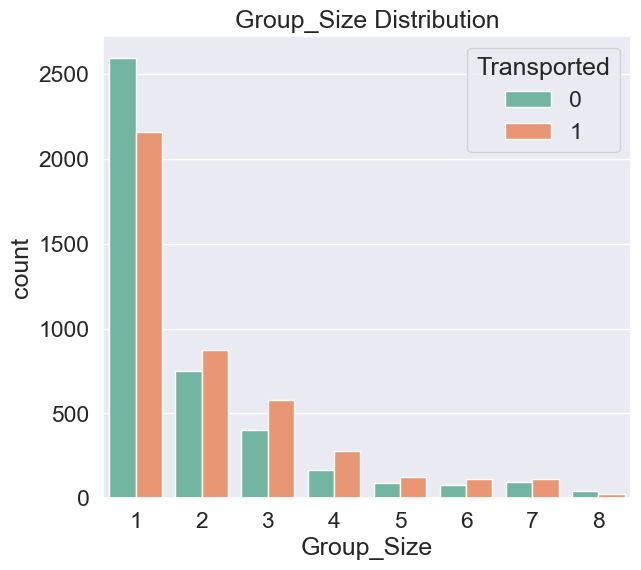

In [188]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='Group_Size', hue='Transported', data=train_df, palette="Set2")
plt.title("Group_Size Distribution")
plt.show()

### Compare Deck with Transported

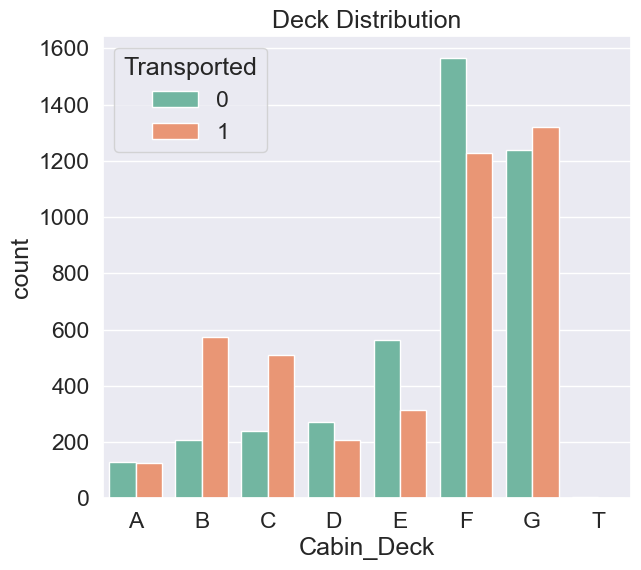

In [189]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='Cabin_Deck', hue='Transported', data=train_df, palette="Set2", order=['A', 'B', 'C', 'D', 'E','F','G','T'])
plt.title("Deck Distribution")
plt.show()

### Compare Cabin_Number with Transported

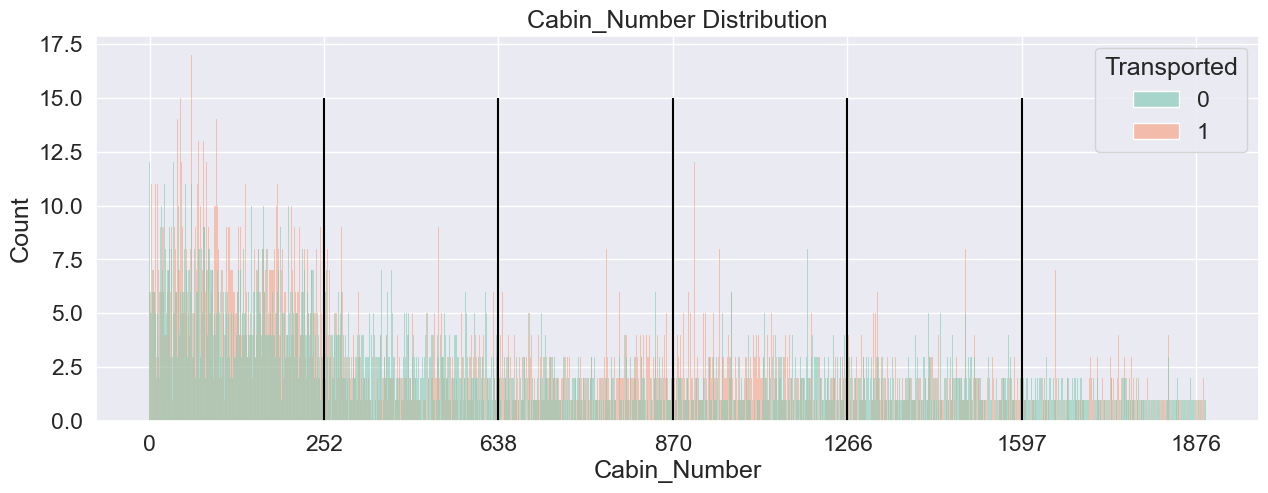

In [190]:
plt.figure(figsize=(15, 5))
subset_df = train_df.sample(frac=1)  # Adjust the fraction as needed
sns.histplot(x="Cabin_Number", data=train_df, hue="Transported", palette="Set2")
plt.title("Cabin_Number Distribution")
plt.xticks(list(range(0, 1900, 300)))
plt.vlines(300, ymin=0, ymax=15, color="black")
plt.vlines(600, ymin=0, ymax=15, color="black")
plt.vlines(900, ymin=0, ymax=15, color="black")
plt.vlines(1200, ymin=0, ymax=15, color="black")
plt.vlines(1500, ymin=0, ymax=15, color="black")
plt.show()

Create Cabin Categories

In [191]:
def cabin_regions(df):
    df["Cabin_Number"] = pd.to_numeric(df["Cabin_Number"], errors='coerce')
    df["Cabin_Region1"] = (df["Cabin_Number"]<252)
    df["Cabin_Region2"] = (df["Cabin_Number"]>=252) & (df["Cabin_Number"]<638)
    df["Cabin_Region3"] = (df["Cabin_Number"]>=638) & (df["Cabin_Number"]<870)
    df["Cabin_Region4"] = (df["Cabin_Number"]>=870) & (df["Cabin_Number"]<1266)
    df["Cabin_Region5"] = (df["Cabin_Number"]>=1266) & (df["Cabin_Number"]<1597)
    df["Cabin_Region6"] = (df["Cabin_Number"]>=1876)

In [192]:
cabin_regions(train_df)

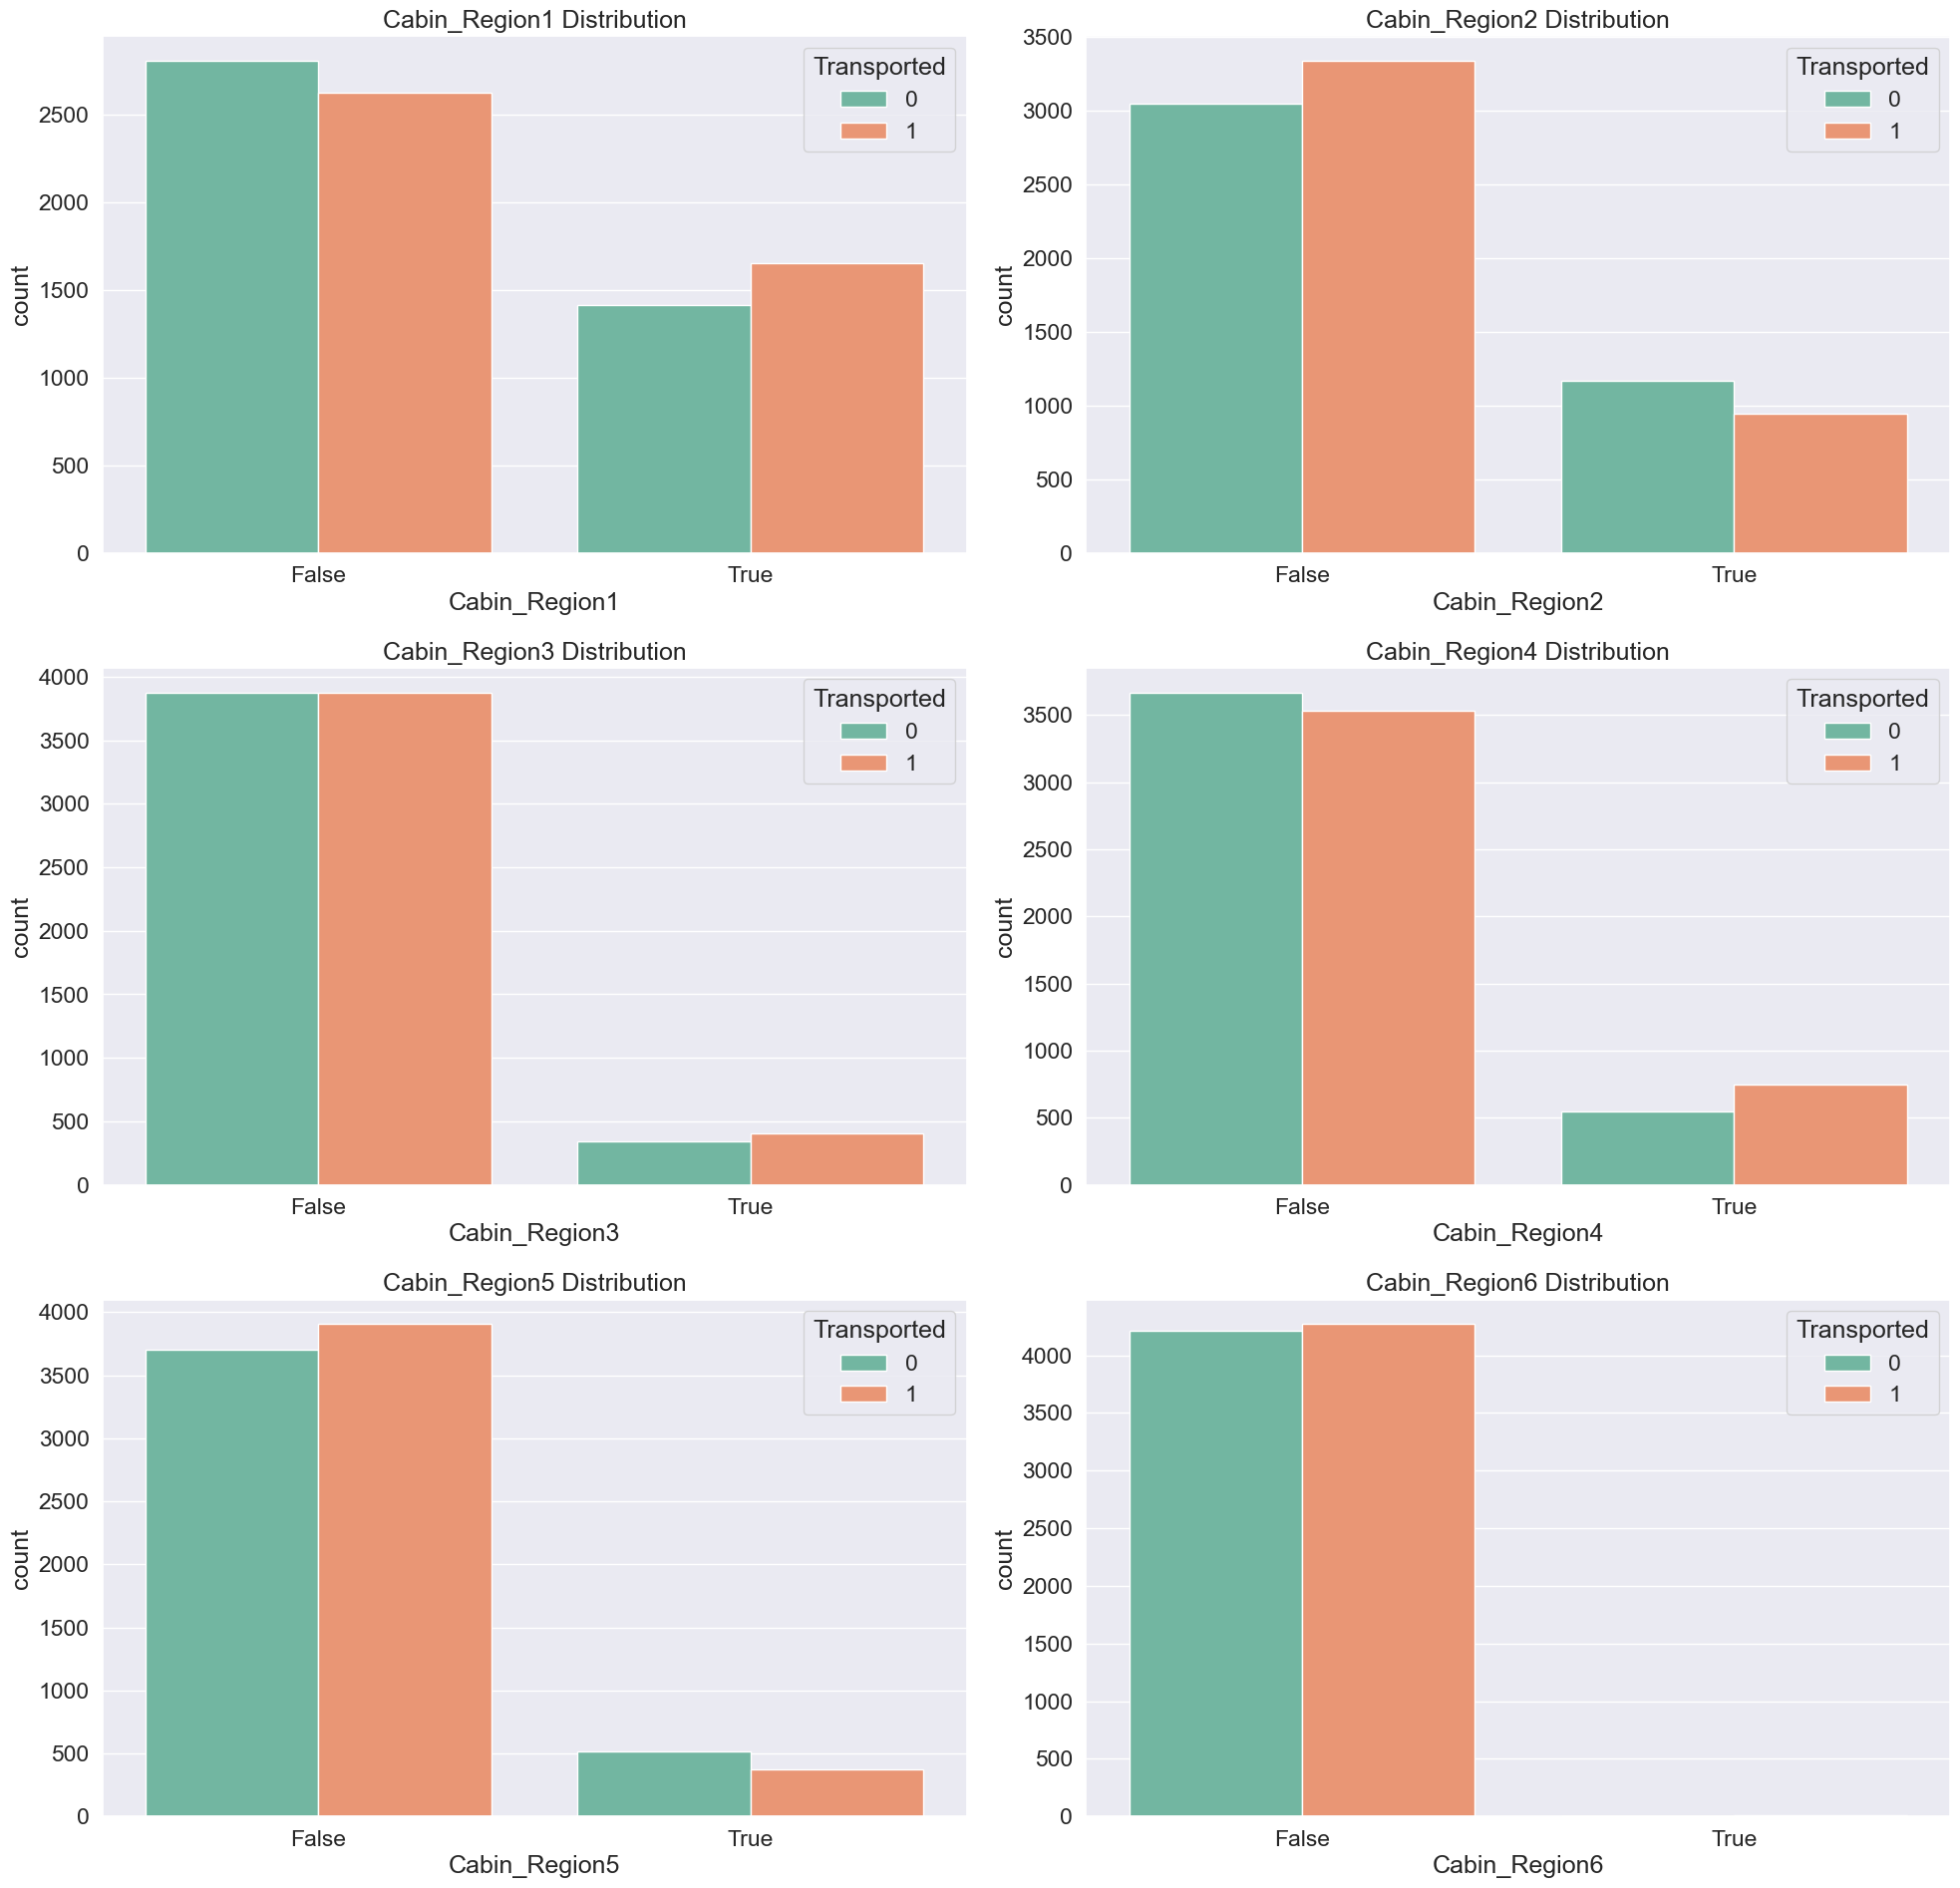

In [193]:
cols = ["Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6"]

plt.figure(figsize=(20,25))
for idx,value in enumerate(cols):
    plt.subplot(4,2,idx+1)
    sns.countplot(x=value, hue="Transported", data=train_df, palette="Set2")
    plt.title(f"{value} Distribution")
    plt.tight_layout()

### Check if people in the same cabin are transported

The data shows that if someone gets transported, then at least 30% of the people sharing the same room disappear.
It is either a majority disappears or a majority doesn't disappear, which may show correlation between Cabin Number and Transported.

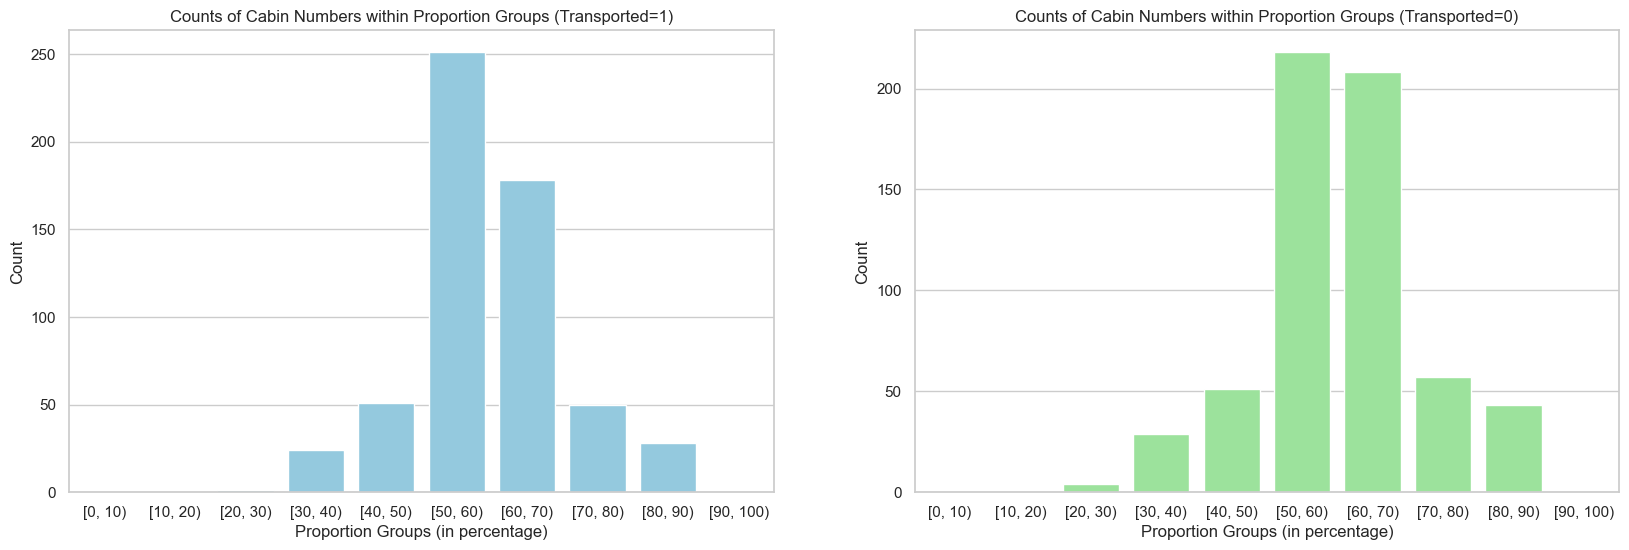

In [194]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Filter rows where 'Transported' is 1
transported_1_df = train_df[train_df['Transported'] == 1]

# Group by 'Cabin_Number' and 'Group_Size' and calculate the count
cabin_group_counts_1 = transported_1_df.groupby(['Cabin_Number', 'Group_Size']).size().unstack(fill_value=0)

# Calculate the proportion for each 'Group_Size' when 'Transported' is 1
cabin_group_proportion_1 = cabin_group_counts_1.div(cabin_group_counts_1.sum(axis=1), axis=0)

# Create groups for proportions with intervals of 10
cabin_group_proportion_1['Proportion_Group'] = pd.cut(cabin_group_proportion_1.max(axis=1) * 100, bins=range(0, 110, 10), right=False)

# Count the occurrences of each Proportion_Group for transported 1
group_counts_1 = cabin_group_proportion_1['Proportion_Group'].value_counts(sort=False)

# Filter rows where 'Transported' is 0
transported_0_df = train_df[train_df['Transported'] == 0]

# Group by 'Cabin_Number' and 'Group_Size' and calculate the count
cabin_group_counts_0 = transported_0_df.groupby(['Cabin_Number', 'Group_Size']).size().unstack(fill_value=0)

# Calculate the proportion for each 'Group_Size' when 'Transported' is 0
cabin_group_proportion_0 = cabin_group_counts_0.div(cabin_group_counts_0.sum(axis=1), axis=0)

# Create groups for proportions with intervals of 10
cabin_group_proportion_0['Proportion_Group'] = pd.cut(cabin_group_proportion_0.max(axis=1) * 100, bins=range(0, 110, 10), right=False)

# Count the occurrences of each Proportion_Group for transported 0
group_counts_0 = cabin_group_proportion_0['Proportion_Group'].value_counts(sort=False)

# Plot the proportions for transported 1 and transported 0 side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for transported 1
sns.barplot(ax=axes[0], x=group_counts_1.index.astype(str), y=group_counts_1.values, color='skyblue')
axes[0].set_title("Counts of Cabin Numbers within Proportion Groups (Transported=1)")
axes[0].set_xlabel("Proportion Groups (in percentage)")
axes[0].set_ylabel("Count")

# Plot for transported 0
sns.barplot(ax=axes[1], x=group_counts_0.index.astype(str), y=group_counts_0.values, color='lightgreen')
axes[1].set_title("Counts of Cabin Numbers within Proportion Groups (Transported=0)")
axes[1].set_xlabel("Proportion Groups (in percentage)")
axes[1].set_ylabel("Count")

plt.show()

### Compare Side with Transported

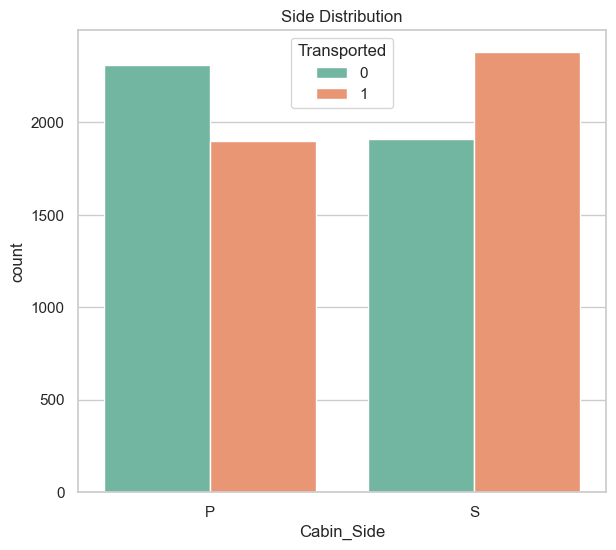

In [195]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='Cabin_Side', hue='Transported', data=train_df, palette="Set2")
plt.title("Side Distribution")
plt.show()

### Compare Total_Expenditure with Transported

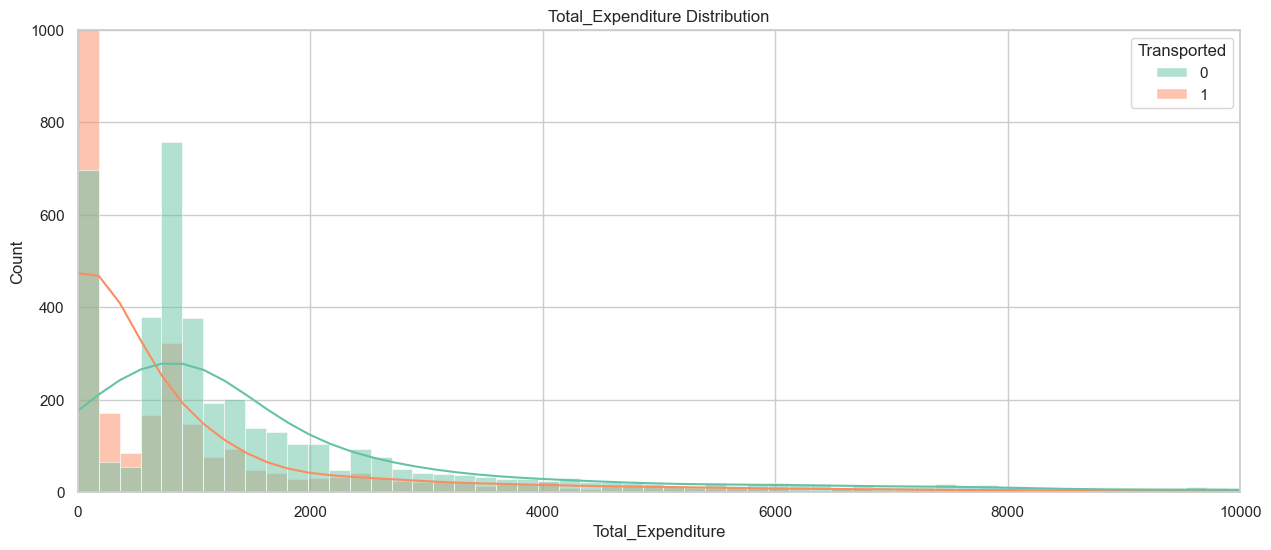

In [196]:
plt.figure(figsize=(15, 6))
sns.histplot(x='Total_Expenditure', hue='Transported', data=train_df, kde=True, palette='Set2', bins=200)
plt.title("Total_Expenditure Distribution")
plt.ylim(0, 1000)
plt.xlim(0, 10000)
plt.show()

### split group_size into categories

In [197]:
# Define the conditions for categorizing Group_Size
conditions = [
    (train_df['Group_Size'] == 1),
    (train_df['Group_Size'] >= 2) & (train_df['Group_Size'] <= 4),
    (train_df['Group_Size'] > 4)
]

# Define the category labels
categories = ['1', '2-4', '>4']

# Create a new column 'Group_Size_Category' based on the conditions
train_df['Group_Size_Category'] = np.select(conditions, categories, default='Unknown')

### Make 0 spending a separate feature

Take out people with 0 expenditure and make it a separate feature
Replot expenditure to find the different categories of Expenditure

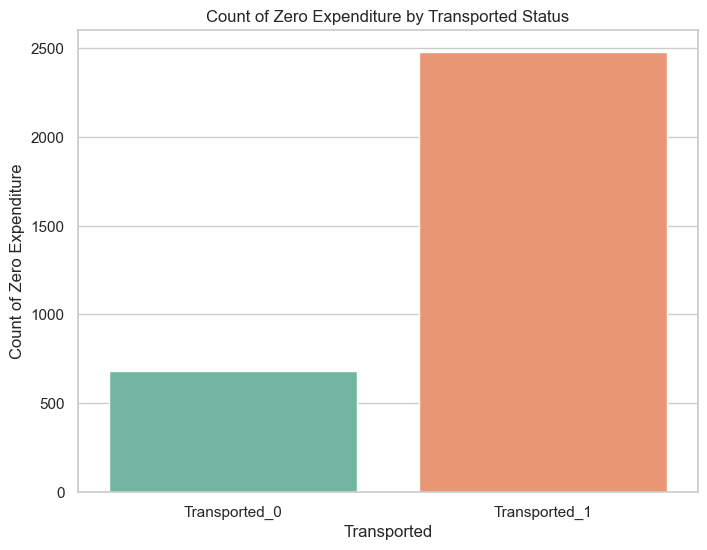

In [198]:
train_df['Zero_Expenditure'] = train_df['Total_Expenditure'].apply(lambda x: 1 if x == 0 else 0)
# Set the style of seaborn
sns.set(style="whitegrid")

# Filter rows where 'Transported' is 0 and 1 separately
transported_0_zero_exp_df = train_df[(train_df['Transported'] == 0) & (train_df['Zero_Expenditure'] == 1)]
transported_1_zero_exp_df = train_df[(train_df['Transported'] == 1) & (train_df['Zero_Expenditure'] == 1)]

# Count the occurrences of zero expenditure for 'Transported' values of 0 and 1
zero_exp_counts = pd.DataFrame({
    'Transported_0': [len(transported_0_zero_exp_df)],
    'Transported_1': [len(transported_1_zero_exp_df)]
})

# Plot the counts
plt.figure(figsize=(8, 6))
sns.barplot(data=zero_exp_counts, palette="Set2")
plt.title("Count of Zero Expenditure by Transported Status")
plt.xlabel("Transported")
plt.ylabel("Count of Zero Expenditure")
plt.xticks(rotation=0)
plt.show()

In [199]:
transported_to_end(train_df)
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group_Size,isInGroup,Cabin_Deck,Cabin_Number,Cabin_Side,Total_Expenditure,Age_Group,Cabin_Region1,Cabin_Region2,Cabin_Region3,Cabin_Region4,Cabin_Region5,Cabin_Region6,Group_Size_Category,Zero_Expenditure,Transported
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1,False,B,0,P,0.0,30-39,True,False,False,False,False,False,1,1,0
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,False,F,0,S,736.0,20-29,True,False,False,False,False,False,1,0,1
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,2,True,A,0,S,10383.0,50-59,True,False,False,False,False,False,2-4,0,0
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,2,True,A,0,S,5176.0,30-39,True,False,False,False,False,False,2-4,0,0
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,False,F,1,S,1091.0,10-19,True,False,False,False,False,False,1,0,1


# Model Building

## Create Groups for Total_Expenditure

In [200]:
def expenditure_category(df):
    df["Total_Expenditure"] = pd.to_numeric(df["Total_Expenditure"], errors='coerce')
    df["Total_Expenditure_Group"] = ""
    df.loc[df["Total_Expenditure"] == 0, "Total_Expenditure_Group"] = "No Expense"
    df.loc[(df["Total_Expenditure"] > 0) & (df["Total_Expenditure"] <= 1000), "Total_Expenditure_Group"] = "Low Expense"
    df.loc[(df["Total_Expenditure"] > 1000) & (df["Total_Expenditure"] <= 2000), "Total_Expenditure_Group"] = "Medium Expense"
    df.loc[(df["Total_Expenditure"] > 2000) & (df["Total_Expenditure"] <= 4000), "Total_Expenditure_Group"] = "High Expense"
    df.loc[df["Total_Expenditure"] > 4000, "Total_Expenditure_Group"] = "Very High Expense"

In [201]:
expenditure_category(train_df)

In [202]:
train_df.drop(columns = ['Name', 'VIP', 'Age', 'Total_Expenditure', 'Group_Size', 'Cabin_Number'],axis = 1, inplace =True)
train_df.head()

,HomePlanet,CryoSleep,Destination,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,isInGroup,Cabin_Deck,Cabin_Side,Age_Group,Cabin_Region1,Cabin_Region2,Cabin_Region3,Cabin_Region4,Cabin_Region5,Cabin_Region6,Group_Size_Category,Zero_Expenditure,Transported,Total_Expenditure_Group
0,Europa,0,TRAPPIST-1e,0.0,0.0,0.0,0.0,0.0,False,B,P,30-39,True,False,False,False,False,False,1,1,0,No Expense
1,Earth,0,TRAPPIST-1e,109.0,9.0,25.0,549.0,44.0,False,F,S,20-29,True,False,False,False,False,False,1,0,1,Low Expense
2,Europa,0,TRAPPIST-1e,43.0,3576.0,0.0,6715.0,49.0,True,A,S,50-59,True,False,False,False,False,False,2-4,0,0,Very High Expense
3,Europa,0,TRAPPIST-1e,0.0,1283.0,371.0,3329.0,193.0,True,A,S,30-39,True,False,False,False,False,False,2-4,0,0,Very High Expense
4,Earth,0,TRAPPIST-1e,303.0,70.0,151.0,565.0,2.0,False,F,S,10-19,True,False,False,False,False,False,1,0,1,Medium Expense


# Category to Numeric

## Label Encoding

In [203]:
def df_le(df):
    label_encoder = LabelEncoder()
    columns_to_encode = ['Age_Group', 'Group_Size_Category', 'Total_Expenditure_Group']
    for col in columns_to_encode:
        # Fit label encoder and transform values to numerical labels
        df[col] = label_encoder.fit_transform(df[col])

df_le(train_df)

## One Hot Encoding:

In [204]:
def df_ohe(df):
    columns_to_encode = ['HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Side']
    for col in columns_to_encode:        
        df[col] = df[col].astype('category')

    df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False)
    
    return df

train_df = df_ohe(train_df)
train_df.head()

,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,isInGroup,Age_Group,Cabin_Region1,Cabin_Region2,Cabin_Region3,Cabin_Region4,Cabin_Region5,Cabin_Region6,Group_Size_Category,Zero_Expenditure,Transported,Total_Expenditure_Group,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,Cabin_Side_P,Cabin_Side_S
0,0,0.0,0.0,0.0,0.0,0.0,False,3,True,False,False,False,False,False,0,1,0,3,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False
1,0,109.0,9.0,25.0,549.0,44.0,False,2,True,False,False,False,False,False,0,0,1,1,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True
2,0,43.0,3576.0,0.0,6715.0,49.0,True,5,True,False,False,False,False,False,1,0,0,4,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True
3,0,0.0,1283.0,371.0,3329.0,193.0,True,3,True,False,False,False,False,False,1,0,0,4,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True
4,0,303.0,70.0,151.0,565.0,2.0,False,1,True,False,False,False,False,False,0,0,1,2,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True


## Change Category to Numeric

In [205]:
bool_columns = ['CryoSleep', 
                'HomePlanet_Europa','HomePlanet_Earth', 'HomePlanet_Mars', 'Destination_PSO J318.5-22', 
                'Destination_TRAPPIST-1e', 'Cabin_Deck_B', 'Cabin_Deck_C', 'Cabin_Deck_D', 
                'Cabin_Deck_E', 'Cabin_Deck_F', 'Cabin_Deck_G', 'Cabin_Deck_T', 'Cabin_Side_S', 
                'Destination_55 Cancri e', 'Cabin_Deck_A', 'Cabin_Side_P', 'Cabin_Region1','Cabin_Region2',
                'Cabin_Region3','Cabin_Region4','Cabin_Region5','Cabin_Region6', 'Group_Size_Category', 
                'Age_Group', 'Transported', 'Total_Expenditure_Group','Zero_Expenditure','isInGroup']

# Convert boolean columns to float64
train_df[bool_columns] = train_df[bool_columns].astype(float)
final_train = train_df
# Display the modified DataFrame with object types
print(final_train.dtypes)
final_train.head()

CryoSleep                    float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
isInGroup                    float64
Age_Group                    float64
Cabin_Region1                float64
Cabin_Region2                float64
Cabin_Region3                float64
Cabin_Region4                float64
Cabin_Region5                float64
Cabin_Region6                float64
Group_Size_Category          float64
Zero_Expenditure             float64
Transported                  float64
Total_Expenditure_Group      float64
HomePlanet_Earth             float64
HomePlanet_Europa            float64
HomePlanet_Mars              float64
Destination_55 Cancri e      float64
Destination_PSO J318.5-22    float64
Destination_TRAPPIST-1e      float64
Cabin_Deck_A                 float64
Cabin_Deck_B                 float64
Cabin_Deck_C                 float64
C

,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,isInGroup,Age_Group,Cabin_Region1,Cabin_Region2,Cabin_Region3,Cabin_Region4,Cabin_Region5,Cabin_Region6,Group_Size_Category,Zero_Expenditure,Transported,Total_Expenditure_Group,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,Cabin_Side_P,Cabin_Side_S
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,109.0,9.0,25.0,549.0,44.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,43.0,3576.0,0.0,6715.0,49.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1283.0,371.0,3329.0,193.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,303.0,70.0,151.0,565.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Find significant features:

### Use Correlation Matrix

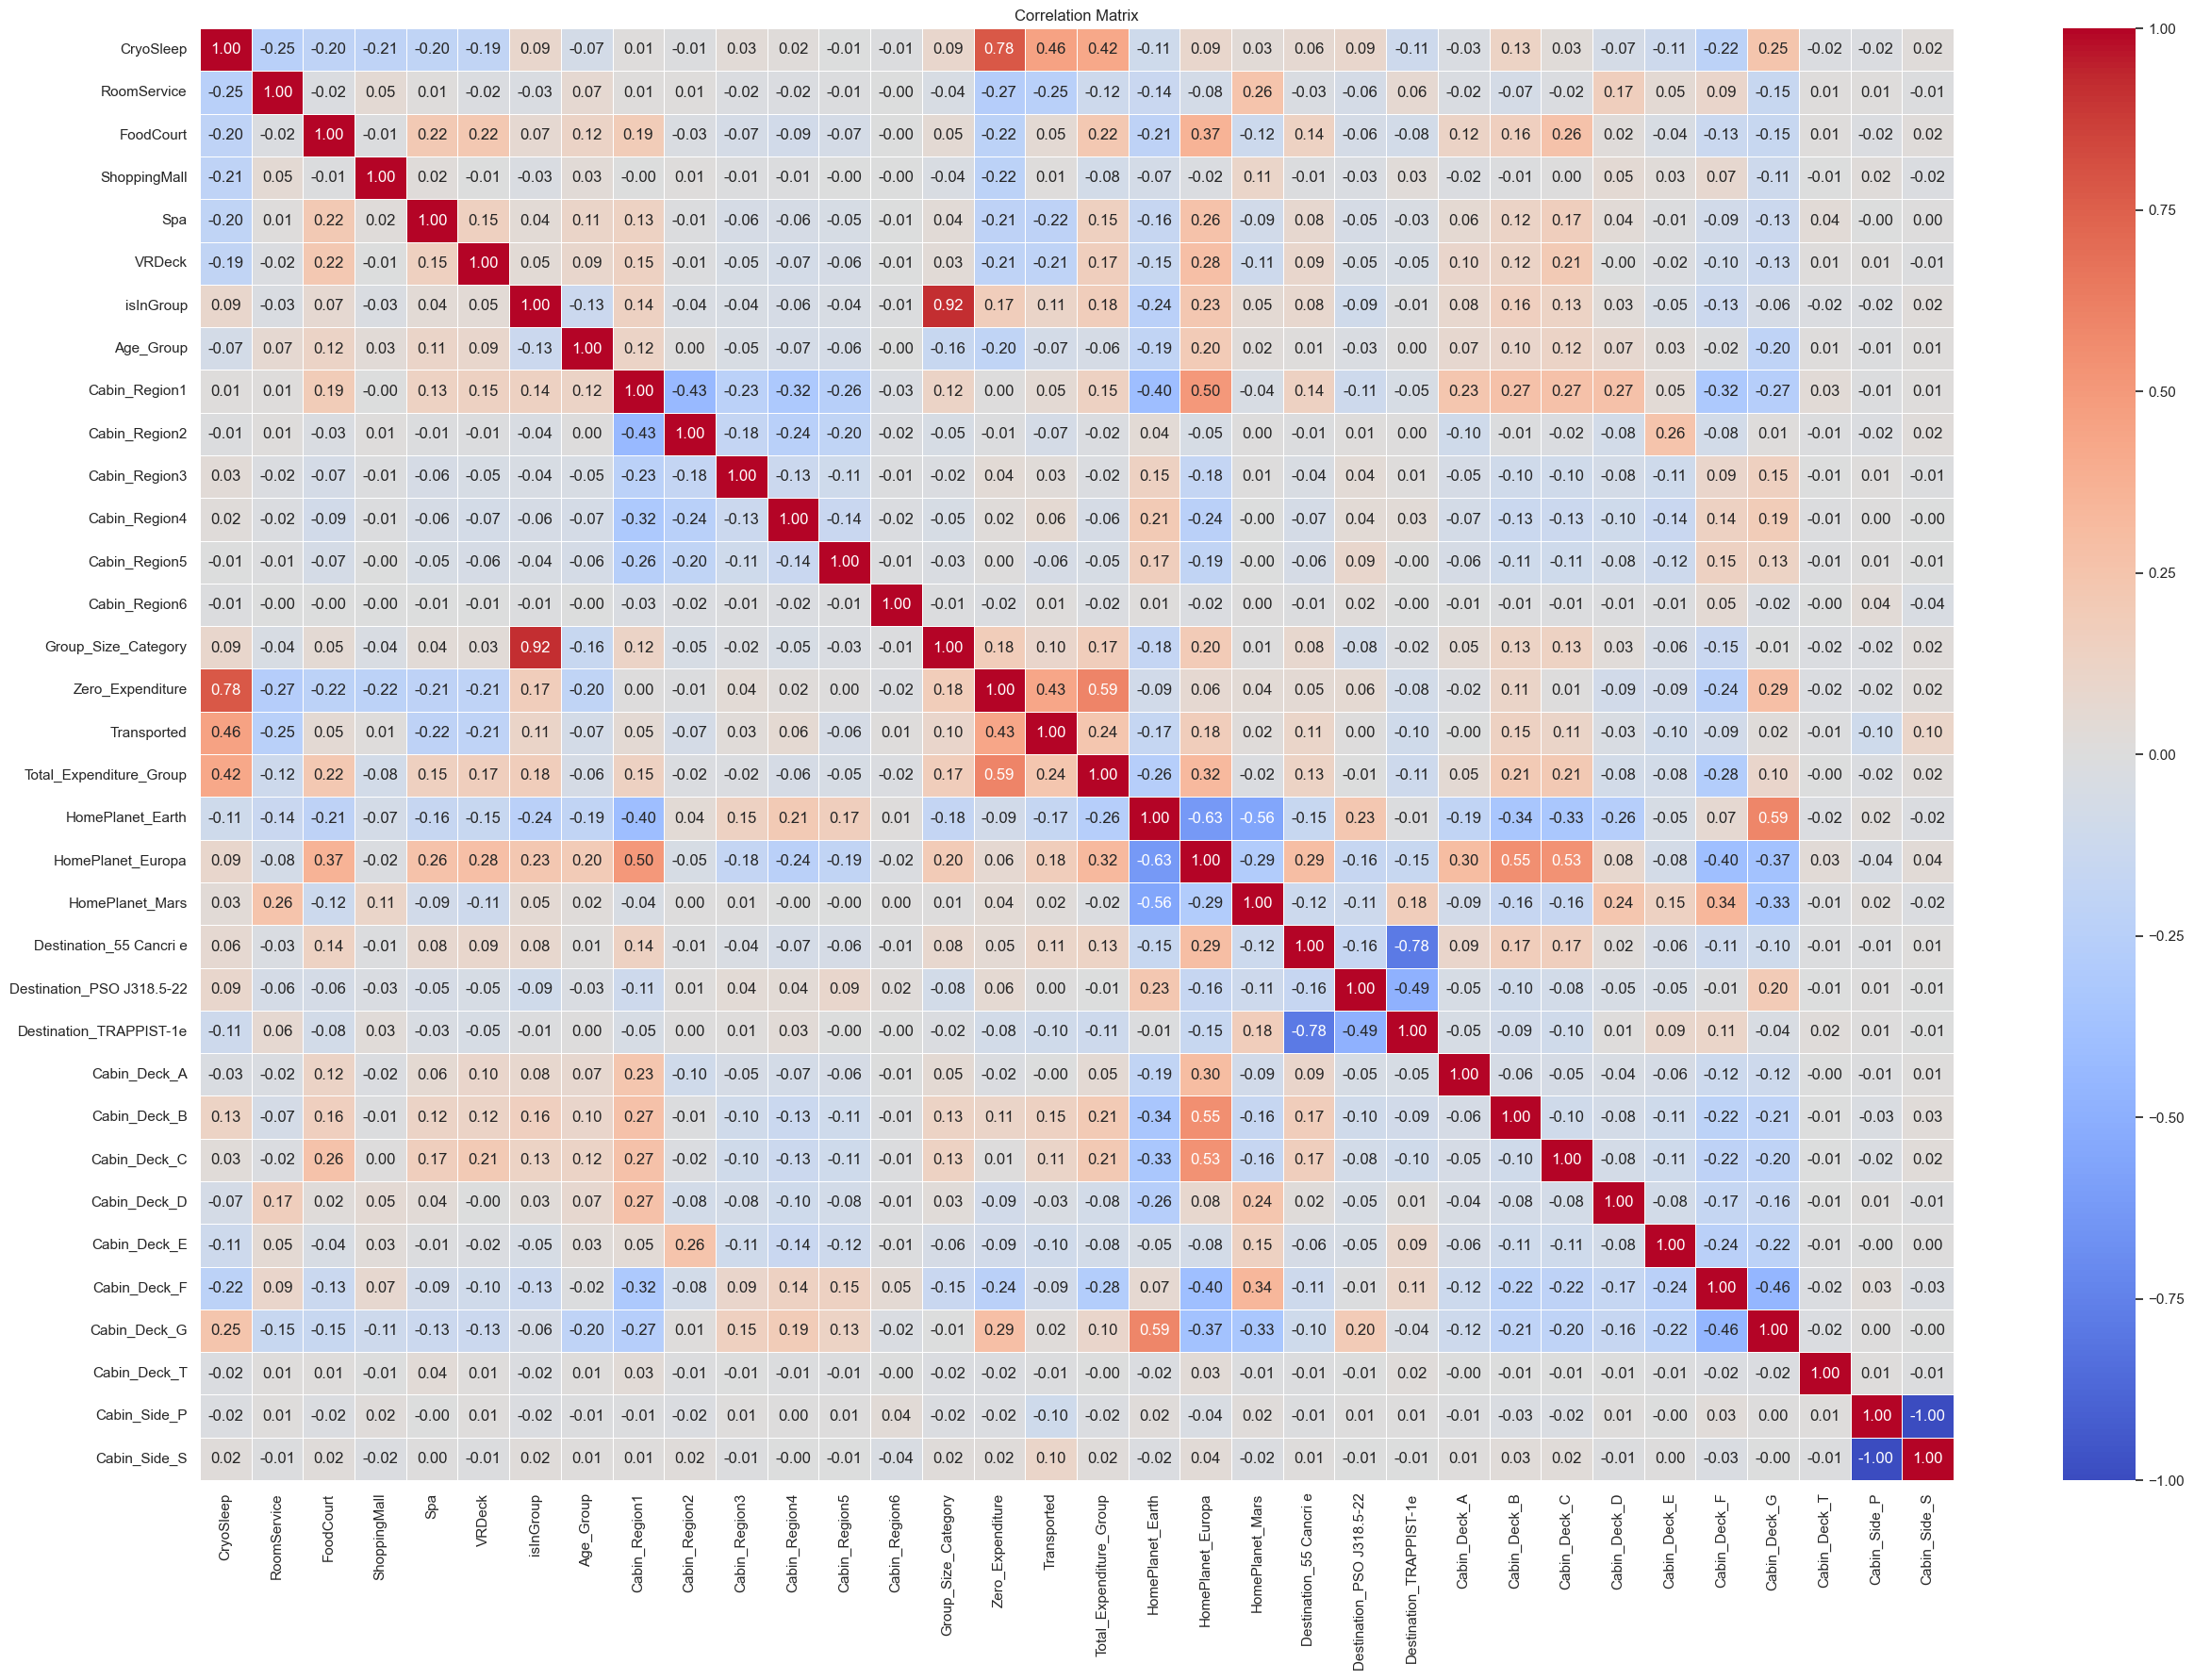

In [206]:
# Calculate correlation matrix
correlation_matrix = final_train.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [207]:
# Filter out correlations equal to 1
corr_matrix_filtered = correlation_matrix[correlation_matrix != 1]

# Flatten the correlation matrix and sort the values
flattened_corr = corr_matrix_filtered.unstack().sort_values(ascending=False)

# Remove duplicates by filtering out correlations where the index is greater than the column
# This ensures we only keep one direction of the correlation
unique_corr = flattened_corr[flattened_corr.index.get_level_values(0) < flattened_corr.index.get_level_values(1)]

## Training

In [208]:
y = final_train['Transported']
x = final_train.drop(columns=['Transported'])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True, stratify=y)

### using PCA

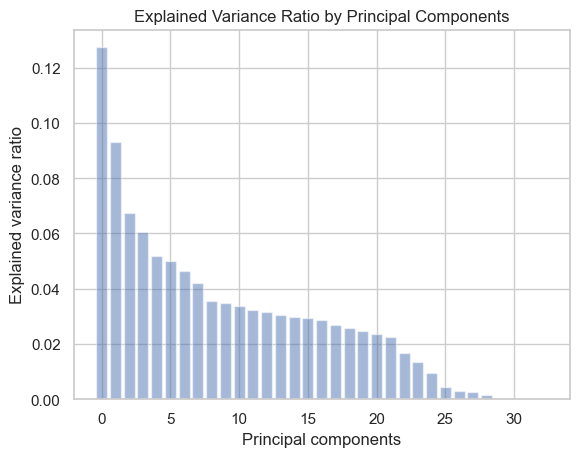

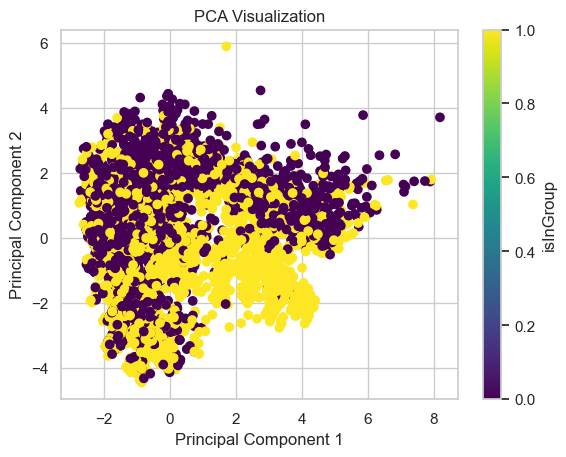

In [209]:
# Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Perform PCA
pca = PCA(n_components=x_train.shape[1])  # PCA with all components
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)

# Visualize the explained variance ratio
explained_variance = pca.explained_variance_ratio_
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

# Visualize the data in reduced dimensions
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.colorbar(label='isInGroup')
plt.show()


## Recursive Feature Eliminator (RFE)
### Logistic Regression

In [210]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'kNN': KNeighborsClassifier(),
    'SVC': SVC(),
    'Linear Regression': GradientBoostingClassifier()
}

# Hyperparameter Tuning

### Decision Tree

In [215]:
pipe_tree_dt = Pipeline([
    ('pca', PCA()),
    ('dt_classifier', DecisionTreeClassifier())
])

dt_param_grid = {
    'dt_classifier__criterion': ['gini', 'entropy'],
    'dt_classifier__splitter': ['best'],
    'dt_classifier__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
    'dt_classifier__max_features': [None, 'sqrt', 'log2']
}

# Create a GridSearchCV object
dt_grid_search = GridSearchCV(estimator=pipe_tree_dt, param_grid=dt_param_grid, cv=5, 
                              scoring='roc_auc', verbose=2, n_jobs=-1, refit=True)

# Fit the GridSearchCV object on training data
dt_grid_search.fit(x_train_scaled, y_train)

# Predict using the best estimator from grid search
grid_dt = dt_grid_search.predict(x_val_scaled)

# Print the best estimator and best parameters
print("Best Estimator:")
print(dt_grid_search.best_estimator_)
print("\nBest Parameters:")
print(dt_grid_search.best_params_)
roc_auc_dt = roc_auc_score(y_val, grid_dt)
print("ROC AUC Score:", roc_auc_dt)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Estimator:
Pipeline(steps=[('pca', PCA()),
                ('dt_classifier', DecisionTreeClassifier(min_samples_leaf=12))])

Best Parameters:
{'dt_classifier__criterion': 'gini', 'dt_classifier__max_features': None, 'dt_classifier__min_samples_leaf': 12, 'dt_classifier__splitter': 'best'}
ROC AUC Score: 0.7194508652897418


### kNN Classifier

In [216]:
knn_param_grid = {
    'knn_classifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10],
    'knn_classifier__weights': ['uniform', 'distance'],
    'knn_classifier__metric': ['euclidean', 'manhattan']
}

pipe_knn = Pipeline([
    ('pca', PCA()),
    ('knn_classifier', KNeighborsClassifier())
])

knn_grid_search = GridSearchCV(estimator=pipe_knn, param_grid=knn_param_grid, cv=5,
                               scoring='roc_auc', verbose=2, n_jobs=-1, refit=True)


# Fit the GridSearchCV object on training data
knn_grid_search.fit(x_train_scaled, y_train)

# Predict using the best estimator from grid search
grid_knn = knn_grid_search.predict(x_val_scaled)

# Print the best estimator and best parameters
print("Best Estimator:")
print(knn_grid_search.best_estimator_)
print("\nBest Parameters:")
print(knn_grid_search.best_params_)
roc_auc_knn = roc_auc_score(y_val, grid_knn)
print("ROC AUC Score:", roc_auc_knn)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Estimator:
Pipeline(steps=[('pca', PCA()),
                ('knn_classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=10))])

Best Parameters:
{'knn_classifier__metric': 'euclidean', 'knn_classifier__n_neighbors': 10, 'knn_classifier__weights': 'uniform'}
ROC AUC Score: 0.7633687542266715


### Support Vector Matrix

svc kernel -> rbf kernel (not linear)

In [219]:
pipe_svc = Pipeline([
    ('pca', PCA()),
    ('svc', SVC())
])

svc_param_grid = {
    'svc__C': [0.1, 1, 10, 100, 1000],
    'svc__kernel': ['rbf'], 
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

svc_grid_search = GridSearchCV(estimator=pipe_svc, param_grid=svc_param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1, refit=True)

svc_grid_search.fit(x_train_scaled, y_train)

# Predict using the best estimator from grid search
grid_svm = svc_grid_search.predict(x_val_scaled)

# Print the best estimator and best parameters
print("Best Estimator:")
print(svc_grid_search.best_estimator_)
print("\nBest Parameters:")
print(svc_grid_search.best_params_)
roc_auc_svm = roc_auc_score(y_val, grid_svm)
print("ROC AUC Score:", roc_auc_svm)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Estimator:
Pipeline(steps=[('pca', PCA()), ('svc', SVC(C=100, gamma=0.001))])

Best Parameters:
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
ROC AUC Score: 0.7933282336116008


### Linear Regression

In [221]:
lr_param_grid = {
    'lr_classifier__C': [0.1, 1, 10],  # Note the prefix 'lr_classifier__' to specify the parameter for Logistic Regression
    'lr_classifier__penalty': ['l2']
}

# Create a pipeline
pipe_lr = Pipeline([
    ('pca', PCA()),
    ('lr_classifier', LogisticRegression())
])

# Create a GridSearchCV object for Logistic Regression
lr_grid_search = GridSearchCV(estimator=pipe_lr, param_grid=lr_param_grid, cv=5, 
                              scoring='roc_auc', verbose=2, n_jobs=-1, refit=True)

# Fit GridSearchCV object on training data
lr_grid_search.fit(x_train_scaled, y_train)

# Predict using the best estimator from grid search
grid_lr = lr_grid_search.predict(x_val_scaled)

# Calculate ROC AUC score on the validation set
roc_auc_lr = roc_auc_score(y_val, grid_lr)

# Print the best parameters and ROC AUC score
print("Logistic Regression:")
print("Best Parameters:", lr_grid_search.best_params_)
print("ROC AUC Score:", roc_auc_lr)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistic Regression:
Best Parameters: {'lr_classifier__C': 10, 'lr_classifier__penalty': 'l2'}
ROC AUC Score: 0.7825620004212814


### Evaluate Models

Train data using the tuned parmaters for the 4 models and compare classification_report
from ROC_AUC curve received from the 4 models, SVM has the best at disciminating between the positive and negative instances across all classification thresholds, 0.79 